In [1]:
import sys
import pandas as pd
import numpy as np
import tensorflow as tf
import json
import string
import re
import time
from datetime import datetime
from collections import Counter

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.metrics import CategoricalAccuracy, CosineSimilarity, F1Score
from tensorflow.keras.regularizers import l2

from joblib import Parallel, delayed

#from method_main import *
#from method_json import *
#from main_ANN_balanced_doc2vec_copy import *
#from main_ANN_TW_meta import ANN_model_training

#dict = read_category_csv_dict("ref_docu/CategoryGroupIndices.csv") 

# Using arXiv major huggingface dataset

In [2]:
JSON_8 = "/Users/sro/2024ML-Research/Performance_Metrics/datasets/minor_train_processed.json"
JSON_9 = "/Users/sro/2024ML-Research/Performance_Metrics/datasets/minor_test_processed.json"


df_minor_train = pd.read_json(JSON_8, lines = "True")
df_minor_test = pd.read_json(JSON_9, lines = "True")
formatted_num_rows = "{:,}".format(len(df_minor_train))
print(f"Total number of minor train set rows: {formatted_num_rows}\n")
formatted_num_rows = "{:,}".format(len(df_minor_test))
print(f"Total number of minor test set rows: {formatted_num_rows}\n")

'''
JSON_10 = "/Users/sro/2024ML-Research/Performance_Metrics/datasets/major_train_processed.json"
JSON_11 = "/Users/sro/2024ML-Research/Performance_Metrics/datasets/major_test_processed.json"

df_major_train = pd.read_json(JSON_10, lines = "True")
df_major_test = pd.read_json(JSON_11, lines = "True")
formatted_num_rows = "{:,}".format(len(df_major_train))
print(f"Total number of major train set rows: {formatted_num_rows}\n")
formatted_num_rows = "{:,}".format(len(df_major_test))
print(f"Total number of major test set rows: {formatted_num_rows}\n")'''

Total number of minor train set rows: 108,696

Total number of minor test set rows: 27,178



'\nJSON_10 = "/Users/sro/2024ML-Research/Performance_Metrics/datasets/major_train_processed.json"\nJSON_11 = "/Users/sro/2024ML-Research/Performance_Metrics/datasets/major_test_processed.json"\n\ndf_major_train = pd.read_json(JSON_10, lines = "True")\ndf_major_test = pd.read_json(JSON_11, lines = "True")\nformatted_num_rows = "{:,}".format(len(df_major_train))\nprint(f"Total number of major train set rows: {formatted_num_rows}\n")\nformatted_num_rows = "{:,}".format(len(df_major_test))\nprint(f"Total number of major test set rows: {formatted_num_rows}\n")'

In [3]:
df_minor_train.columns

Index(['paper_id', 'version', 'yymm', 'created', 'title', 'secondary_subfield',
       'abstract', 'primary_subfield', 'field', 'fulltext',
       'processed_title_abstract_fulltext', 'processed_title_abstract'],
      dtype='object')

In [4]:
df_minor_train['title'][1]

'Discontinuous Euler instability in nanoelectromechanical systems'

In [5]:
df_minor_train['processed_title_abstract_fulltext'][1]

['discontinuous',
 'euler',
 'instability',
 'nanoelectromechanical',
 'systems',
 'investigate',
 'nanoelectromechanical',
 'systems',
 'near',
 'mechanical',
 'instabilities',
 'show',
 'quite',
 'generally',
 'interaction',
 'electronic',
 'vibronic',
 'degrees',
 'freedom',
 'accounted',
 'essentially',
 'exactly',
 'instability',
 'continuous',
 'apply',
 'general',
 'framework',
 'euler',
 'buckling',
 'instability',
 'find',
 'interaction',
 'electronic',
 'vibronic',
 'degrees',
 'freedom',
 'qualitatively',
 'affects',
 'mechanical',
 'instability',
 'turning',
 'discontinuous',
 'one',
 'close',
 'analogy',
 'tricritical',
 'points',
 'landau',
 'theory',
 'phase',
 'transitions',
 'discontinuous',
 'euler',
 'instability',
 'nanoelectromechanical',
 'systems',
 'guillaume',
 'weick1',
 '2',
 'fabio',
 'pistolesi3',
 '4',
 'eros',
 'mariani1',
 '5',
 'felix',
 'von',
 'oppen1',
 '1dahlem',
 'center',
 'complex',
 'quantum',
 'systems',
 'fachbereich',
 'physik',
 'freie',
 'u

In [6]:
df_minor_train['fulltext'][1]

'\nDiscontinuous Euler instability in nanoelectromechanical systems\n\nGuillaume Weick,1, 2 Fabio Pistolesi,3, 4 Eros Mariani,1, 5 and Felix von Oppen1\n\n1Dahlem Center for Complex Quantum Systems and Fachbereich Physik,\n\nFreie Universitat Berlin, D-14195 Berlin, Germany\n\n2IPCMS (UMR 7504), CNRS and Universit´e de Strasbourg, F-67034 Strasbourg, France\n3CPMOH (UMR 5798), CNRS and Universit´e de Bordeaux I, F-33405 Talence, France\n4LPMMC (UMR 5493), CNRS and Universit´e Joseph Fourier, F-38042 Grenoble, France\n\n5School of Physics, University of Exeter, Stocker Road, Exeter, EX4 4QL, UK\n\n(Dated: November 1, 2018)\n\nWe investigate nanoelectromechanical systems near mechanical instabilities. We show that quite\ngenerally, the interaction between the electronic and the vibronic degrees of freedom can be ac-\ncounted for essentially exactly when the instability is continuous. We apply our general framework\nto the Euler buckling instability and find that the interaction between e

Extracting training embeddings from doc2vec model

In [7]:
import logging
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPClassifier

#enable logging to monitor training loss
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#load doc2vec model that you have trained using the doc2vec_training.py script 
DOC2VEC_model = "/Users/sro/2024ML-Research/Performance_Metrics/datasets/doc2vec_model_Cornell_minor_100_3_6"

loaded_model = Doc2Vec.load(DOC2VEC_model)
# df_v188_subset_90_tokens = pd.read_json(processed_path, lines = True, dtype={'id': str})
#processed_title_authors_abstracts = [entry.spilt() for entry in df_minor_train['processed_title_authors_abstract']]

#data = []
#abstracts = [sentence.split() for sentence in df_major_train['abstract']]
#titles = [sentence.split() for sentence in df_major_train['title']]
#unique_id = [id for id in df_major_train['paper_id']]
#categories = [sentence for sentence in df_major_train['primary_subfield']]
#primary_categories = [category.split()[0] for category in categories]
#for title, abstract in zip(titles, abstracts):
#    combined = title + abstract
#    data.append(combined)

inferred_vectors = []
data = df_minor_train["processed_title_abstract"]

def infer_vector(doc, steps=100, alpha=0.001): 
    return loaded_model.infer_vector(doc)
#use ThreadPoolExecutor to parallelize the inference
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(infer_vector, doc, steps=100, alpha=0.001) for doc in data]
    inferred_vectors = [future.result() for future in as_completed(futures)]

#normalize the inferred vectors
scaler = StandardScaler()
normalized_inferred_vectors = scaler.fit_transform(inferred_vectors)

print("Doc2vec model successfully inferred: ")
normalized_inferred_vectors_np = np.array(normalized_inferred_vectors)

#save inferred_vectors_np to .npy file
output_name = f'Performance_Metrics/datasets/X_train.npy'
np.save(output_name, normalized_inferred_vectors_np)

2024-08-20 14:57:30,154 : INFO : loading Doc2Vec object from /Users/sro/2024ML-Research/Performance_Metrics/datasets/doc2vec_model_Cornell_minor_100_3_6
2024-08-20 14:57:30,975 : INFO : loading dv recursively from /Users/sro/2024ML-Research/Performance_Metrics/datasets/doc2vec_model_Cornell_minor_100_3_6.dv.* with mmap=None
2024-08-20 14:57:30,976 : INFO : loading vectors from /Users/sro/2024ML-Research/Performance_Metrics/datasets/doc2vec_model_Cornell_minor_100_3_6.dv.vectors.npy with mmap=None
2024-08-20 14:57:30,998 : INFO : loading wv recursively from /Users/sro/2024ML-Research/Performance_Metrics/datasets/doc2vec_model_Cornell_minor_100_3_6.wv.* with mmap=None
2024-08-20 14:57:30,999 : INFO : loading vectors from /Users/sro/2024ML-Research/Performance_Metrics/datasets/doc2vec_model_Cornell_minor_100_3_6.wv.vectors.npy with mmap=None
2024-08-20 14:57:31,649 : INFO : loading syn1neg from /Users/sro/2024ML-Research/Performance_Metrics/datasets/doc2vec_model_Cornell_minor_100_3_6.syn

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from collections import Counter

categories = df_minor_train['primary_subfield']
primary_categories = [category.split()[0] for category in categories]
y_train = primary_categories

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_integer = label_encoder.transform(y_train)
num_categories = len(label_encoder.classes_)
#print(label_encoder.classes_)
y_train_one_hot = to_categorical(y_integer, num_classes = num_categories)
y_train_one_hot_np = np.array(y_train_one_hot) 
np.save(f'/Users/sro/2024ML-Research/Performance_Metrics/datasets/y_train.npy', y_train_one_hot_np) 

Extracting testing embeddings from doc2vec model

In [6]:
from concurrent.futures import ThreadPoolExecutor, as_completed

DOC2VEC_model = "/Users/sro/2024ML-Research/Performance_Metrics/datasets/doc2vec_model_Cornell_minor_100_3_6"

loaded_model = Doc2Vec.load(DOC2VEC_model)

#data = []
#abstracts = [sentence.split() for sentence in df_major_test['abstract']]
#titles = [sentence.split() for sentence in df_major_test['title']]
# Combine/concatenate the lists of words
#for title, abstract in zip(titles, abstracts):
#    combined = title + abstract
#    data.append(combined)

inferred_vectors = []
data = df_minor_test["processed_title_abstract"]

# steps=50, alpha=0.01
def infer_vector(doc, steps=100, alpha=0.001):
    return loaded_model.infer_vector(doc)
# Use ThreadPoolExecutor to parallelize the inference
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(infer_vector, doc, steps=100, alpha=0.001) for doc in data]
    inferred_vectors = [future.result() for future in as_completed(futures)]

# Normalize the test inferred vectors
# scaler has been fit for training inferred vector, so we just transform the test inferred vectors to ensure consistency 
normalized_inferred_vectors = scaler.transform(inferred_vectors)

print("Doc2vec model successfully inferred: ")
normalized_inferred_vectors_np = np.array(normalized_inferred_vectors)

# Save inferred_vectors_np to .npy file
output_name = f'Performance_Metrics/datasets/X_test.npy'
np.save(output_name, normalized_inferred_vectors_np)

2024-07-28 21:16:23,618 : INFO : loading Doc2Vec object from /Users/sro/2024ML-Research/Performance_Metrics/datasets/doc2vec_model_Cornell_minor_100_3_6
2024-07-28 21:16:24,311 : INFO : loading dv recursively from /Users/sro/2024ML-Research/Performance_Metrics/datasets/doc2vec_model_Cornell_minor_100_3_6.dv.* with mmap=None
2024-07-28 21:16:24,312 : INFO : loading vectors from /Users/sro/2024ML-Research/Performance_Metrics/datasets/doc2vec_model_Cornell_minor_100_3_6.dv.vectors.npy with mmap=None
2024-07-28 21:16:24,328 : INFO : loading wv recursively from /Users/sro/2024ML-Research/Performance_Metrics/datasets/doc2vec_model_Cornell_minor_100_3_6.wv.* with mmap=None
2024-07-28 21:16:24,329 : INFO : loading vectors from /Users/sro/2024ML-Research/Performance_Metrics/datasets/doc2vec_model_Cornell_minor_100_3_6.wv.vectors.npy with mmap=None
2024-07-28 21:16:24,825 : INFO : loading syn1neg from /Users/sro/2024ML-Research/Performance_Metrics/datasets/doc2vec_model_Cornell_minor_100_3_6.syn

Doc2vec model successfully inferred: 


In [7]:
categoriess = [sentence for sentence in df_minor_test['primary_subfield']]
y_test = [category.split()[0] for category in categoriess]
y_test_integer = label_encoder.transform(y_test)

num_training_categories = len(set(y_train))
y_test_one_hot = to_categorical(y_test_integer, num_classes = num_training_categories)
y_test_one_hot_np = np.array(y_test_one_hot) 
np.save(f'/Users/sro/2024ML-Research/Performance_Metrics/datasets/y_test.npy', y_test_one_hot_np) 

# hyperparameters fine tuning 

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.0118 - cosine_similarity: 0.0705 - loss: 5.2480 - precision: 0.0165 - recall: 3.2759e-05
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.0628 - cosine_similarity: 0.1402 - loss: 4.3976 - precision: 0.3336 - recall: 0.0026
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1802 - cosine_similarity: 0.2685 - loss: 3.3285 - precision: 0.4162 - recall: 0.0362
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2593 - cosine_similarity: 0.3480 - loss: 2.8370 - precision: 0.5125 - recall: 0.0813
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3084 - cosine_similarity: 0.3930 - loss: 2.6029 - precision: 0.5488 - recall: 0.1131
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3401 - cosine_similarity: 0.4216 - loss: 2.4602 - precision: 0.5796 - recall: 0.1413
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3603 - cosine_similarity: 0.440

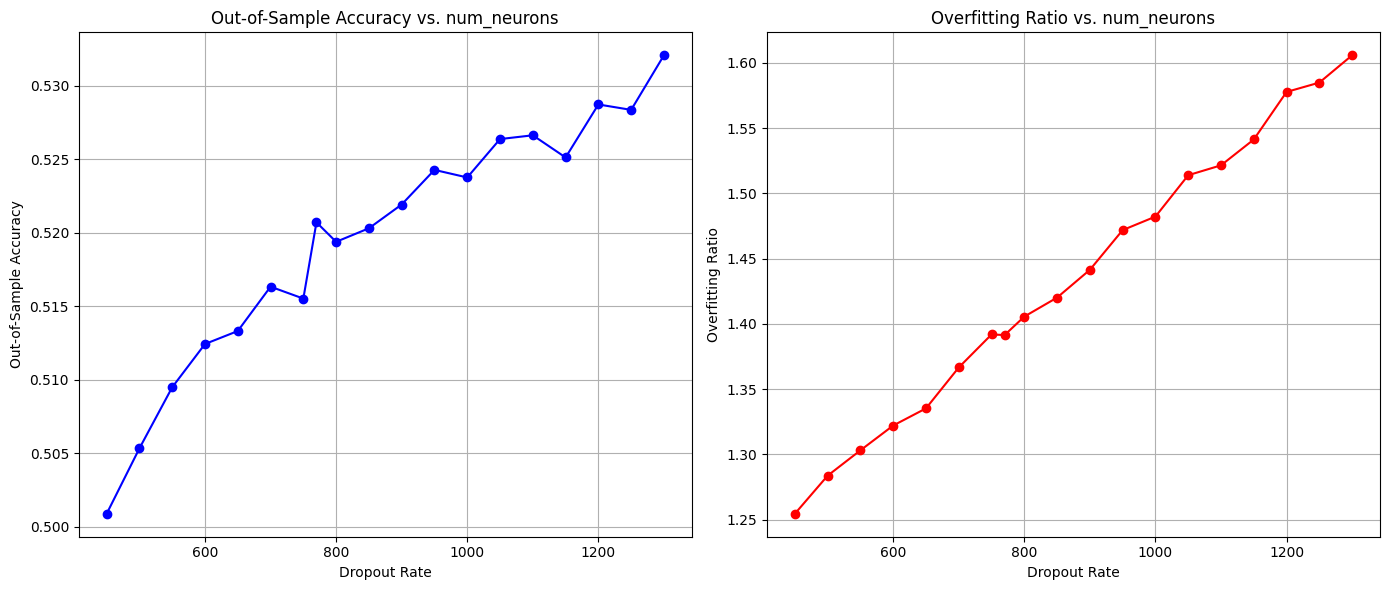

In [34]:
# JSON_extracted_vectors = "/Users/sro/2024ML-Research/Performance_Metrics/datasets/X.npy"
import matplotlib.pyplot as plt
VECTOR_SIZE = 300
num_training_categories = len(label_encoder.classes_)
start_time = time.perf_counter()
try:
    # Load datasets
    X_test = np.load('/Users/sro/2024ML-Research/Performance_Metrics/datasets/X_test.npy')
    y_test = np.load('/Users/sro/2024ML-Research/Performance_Metrics/datasets/y_test.npy')
    X_train = np.load('/Users/sro/2024ML-Research/Performance_Metrics/datasets/X_train.npy')
    y_train = np.load('/Users/sro/2024ML-Research/Performance_Metrics/datasets/y_train.npy')

    num_neurons_configs = [450, 500, 550, 600, 650, 700, 750, 770, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300]
    #num_neurons = 800
    # 800 is best for major 
    #dropout_rates = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
    dropout_rate = 0.64

    out_of_sample_accuracies = []
    overfitting_ratios = []

    with open("/Users/sro/2024ML-Research/Performance_Metrics/datasets/summary.txt", 'a') as file:
        file.write("\n════════════════════════════════════\n")
        file.write("ANN's performance metrics with 0.001 LR, 2048 batch_size, 30 epochs, 2 hidden layers with various num of neurons and {dropout_rate} dropout\n")
        file.write("ANN is trained on embeddings of {VECTOR_SIZE} vector size, inferred with step=100, alpha=0.001, using titles + abstracts from Cornell huggingface major dataset. \n")
        file.write("Doc2vec is trained on titles + abstracts + fulltexts from major dataset with epoch = 100, alpha=0.02, min_alpha=0.0001 \n")
        
        for num_neurons in num_neurons_configs:
            file.write(f"\nConfiguration: {num_neurons} neurons in each hidden layer\n")
            
            # Define regularization parameters
            l2_regularization_factor = 0.01

            # Build the model
            arXiv_classification_model = tf.keras.Sequential([
                tf.keras.layers.Input(shape=(VECTOR_SIZE,)),
                #tf.keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=l2(l2_regularization_factor)),
                #tf.keras.layers.Dropout(dropout_rate),
                tf.keras.layers.Dense(num_neurons, activation='relu'),
                tf.keras.layers.Dropout(dropout_rate),
                tf.keras.layers.Dense(num_neurons, activation='relu'),
                tf.keras.layers.Dropout(dropout_rate),
                tf.keras.layers.Dense(num_training_categories, activation='softmax')
            ])
            # Compile the model
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
            # Compile the model & TensorFlow with Metal automatically distribute operations across available GPUs      
            arXiv_classification_model.compile(optimizer=optimizer,
                        loss='categorical_crossentropy',  # a multi-category classification task expects the targets to be in one-hot encoded format
                        metrics=[
                            'accuracy',                                      # Basic accuracy
                            tf.keras.metrics.Precision(name='precision'),    # Precision metric
                            tf.keras.metrics.Recall(name='recall'),          # Recall metric
                            CosineSimilarity(name='cosine_similarity')       # Cosine Similarity    
                        ])
            
            # Fitting an ANN model
            History = arXiv_classification_model.fit(X_train, y_train, batch_size=2048, epochs=20, verbose=1)
            # batch_size = 512 seems to be "optimal" for training speed while using gpus with METAL support on Mac
            # h5 format is fine, but we should use the native Keras format for saving models
            arXiv_classification_model.save("/Users/sro/2024ML-Research/Performance_Metrics/datasets/v188_ANN_model.keras")
            # In-sample performance metrics
            file.write("\nIn sample performance metrics: \n")
            in_sample_metrics = arXiv_classification_model.evaluate(X_train, y_train, verbose=0)
            file.write(f"Loss: {in_sample_metrics[0]}, Accuracy: {in_sample_metrics[1]}, Precision: {in_sample_metrics[2]}, Recall: {in_sample_metrics[3]}, Cosine Similarity: {in_sample_metrics[4]}" + "\n")
            # Out-of-sample performance metrics
            file.write("\nOut of sample performance metrics: \n")
            out_of_sample_metrics = arXiv_classification_model.evaluate(X_test, y_test, verbose=0)
            file.write(f"Loss: {out_of_sample_metrics[0]}, Accuracy: {out_of_sample_metrics[1]}, Precision: {out_of_sample_metrics[2]}, Recall: {out_of_sample_metrics[3]}, Cosine Similarity: {out_of_sample_metrics[4]}" + "\n")
            #store the out-of-sample accuracy
            out_of_sample_accuracies.append(out_of_sample_metrics[1])
            # Calculate overfitting ratio = test loss / train loss
            overfitting_ratio = out_of_sample_metrics[0] / in_sample_metrics[0]
            overfitting_ratios.append(overfitting_ratio)
            acceptable_threshold = 1.5
            overfitting_status = "acceptable" if overfitting_ratio <= acceptable_threshold else "above threshold"
            file.write(f"Overfitting Ratio: {overfitting_ratio:.2f}\n")
            file.write(f"Overfitting Status: {overfitting_status}\n")
            file.write("\n")

except Exception as e:
    print(f"An error occurred: {e}")

end_time = time.perf_counter()
elapsed_time = end_time - start_time
# Get the current timestamp
current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
# Write the elapsed time and timestamp to the file
with open("/Users/sro/2024ML-Research/Performance_Metrics/datasets/summary.txt", 'a') as file:
    file.write(f"Elapsed time: {elapsed_time / 60} minutes \n")
    file.write(f"Timestamp: {current_time}\n")
# Print the elapsed time and timestamp
print(f"Elapsed time: {elapsed_time / 60} minutes")
print(f"Timestamp: {current_time} \n")

# Plot the results
plt.figure(figsize=(14, 6))

# Plot Out-of-Sample Accuracy
plt.subplot(1, 2, 1)
plt.plot(num_neurons_configs, out_of_sample_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Dropout Rate')
plt.ylabel('Out-of-Sample Accuracy')
plt.title('Out-of-Sample Accuracy vs. num_neurons')
plt.grid(True)

# Plot Overfitting Ratio
plt.subplot(1, 2, 2)
plt.plot(num_neurons_configs, overfitting_ratios, marker='o', linestyle='-', color='r')
plt.xlabel('Dropout Rate')
plt.ylabel('Overfitting Ratio')
plt.title('Overfitting Ratio vs. num_neurons')
plt.grid(True)

plt.tight_layout()
plt.show()

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0469 - cosine_similarity: 0.1115 - loss: 4.7785 - precision: 0.2226 - recall: 0.0029
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2884 - cosine_similarity: 0.3709 - loss: 2.7554 - precision: 0.5347 - recall: 0.1101
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3885 - cosine_similarity: 0.4635 - loss: 2.2705 - precision: 0.6012 - recall: 0.2025
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4297 - cosine_similarity: 0.5018 - loss: 2.0756 - precision: 0.6325 - recall: 0.2486
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4547 - cosine_similarity: 0.5243 - loss: 1.9728 - precision: 0.6513 - recall: 0.2762
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4757 - cosine_similarity: 0.5421 - loss: 1.8885 - precision: 0.6656 - recall: 0.2991
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4835 - cosine_similarity: 0.5516 - 

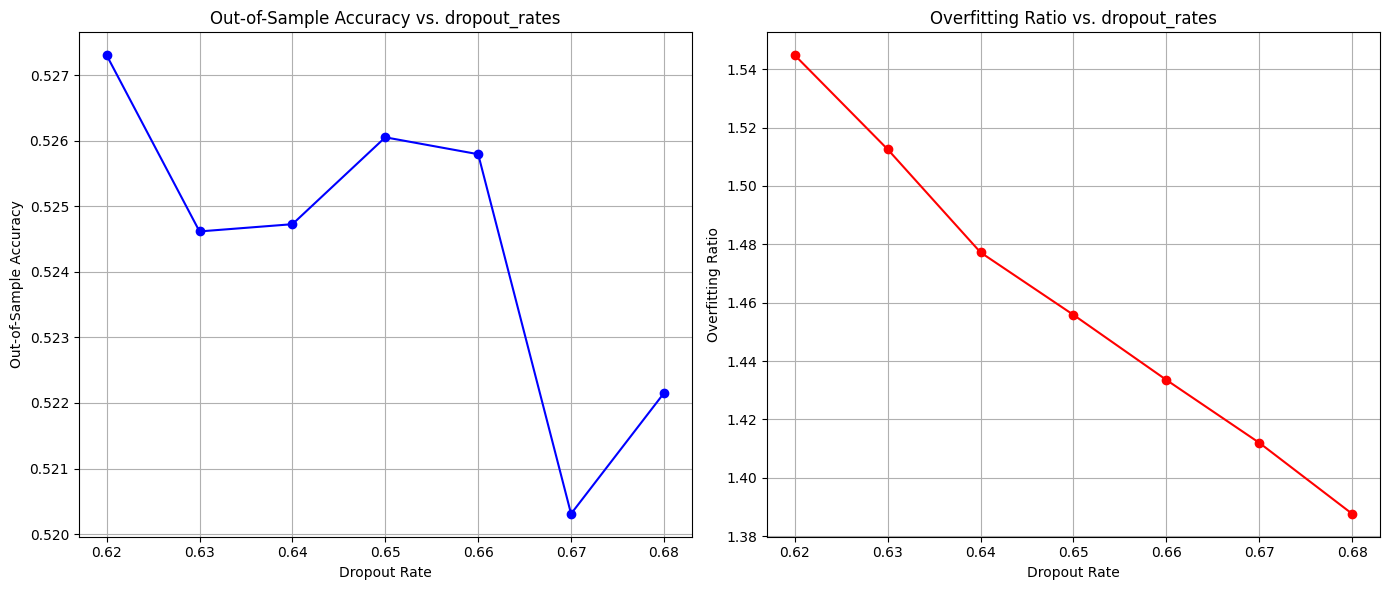

In [30]:
# JSON_extracted_vectors = "/Users/sro/2024ML-Research/Performance_Metrics/datasets/X.npy"
import matplotlib.pyplot as plt
VECTOR_SIZE = 300
num_training_categories = len(label_encoder.classes_)
start_time = time.perf_counter()
try:
    # Load datasets
    X_test = np.load('/Users/sro/2024ML-Research/Performance_Metrics/datasets/X_test.npy')
    y_test = np.load('/Users/sro/2024ML-Research/Performance_Metrics/datasets/y_test.npy')
    X_train = np.load('/Users/sro/2024ML-Research/Performance_Metrics/datasets/X_train.npy')
    y_train = np.load('/Users/sro/2024ML-Research/Performance_Metrics/datasets/y_train.npy')

    #num_neurons_configs = [600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1500]
    num_neurons = 1000
    # 800 is best for major 
    dropout_rates = [0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68]
    dropout_rate = 0.64
    #learning_rates = [0.0001, 0.0005, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007]
    learning_rate = 0.001
    out_of_sample_accuracies = []
    overfitting_ratios = []

    with open("/Users/sro/2024ML-Research/Performance_Metrics/datasets/summary.txt", 'a') as file:
        file.write("\n════════════════════════════════════\n")
        file.write("ANN's performance metrics with 0.001 LR, 2048 batch_size, 20 epochs, 2 hidden layers with various num of neurons and {dropout_rate} dropout\n")
        file.write("ANN is trained on embeddings of {VECTOR_SIZE} vector size, inferred with step=100, alpha=0.001, using titles + abstracts from Cornell huggingface major dataset. \n")
        file.write("Doc2vec is trained on titles + abstracts + fulltexts from major dataset with epoch = 80, alpha=0.03, min_alpha=0.0001 \n")
        
        for dropout_rate in dropout_rates:
            file.write(f"\nConfiguration: {num_neurons} neurons in each hidden layer\n")
            
            # Build the model
            arXiv_classification_model = tf.keras.Sequential([
                tf.keras.layers.Input(shape=(VECTOR_SIZE,)),
                #tf.keras.layers.Dense(num_neurons, activation='relu'),
                #tf.keras.layers.Dropout(dropout_rate),
                tf.keras.layers.Dense(num_neurons, activation='relu'),
                tf.keras.layers.Dropout(dropout_rate),
                tf.keras.layers.Dense(num_neurons, activation='relu'),
                tf.keras.layers.Dropout(dropout_rate),
                tf.keras.layers.Dense(num_training_categories, activation='softmax')
            ])
            # Compile the model
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
            # Compile the model & TensorFlow with Metal automatically distribute operations across available GPUs      
            arXiv_classification_model.compile(optimizer=optimizer,
                        loss='categorical_crossentropy',  # a multi-category classification task expects the targets to be in one-hot encoded format
                        metrics=[
                            'accuracy',                                      # Basic accuracy
                            tf.keras.metrics.Precision(name='precision'),    # Precision metric
                            tf.keras.metrics.Recall(name='recall'),          # Recall metric
                            CosineSimilarity(name='cosine_similarity')       # Cosine Similarity    
                        ])
            
            # Fitting an ANN model
            History = arXiv_classification_model.fit(X_train, y_train, batch_size=2048, epochs=20, verbose=1)
            # batch_size = 512 seems to be "optimal" for training speed while using gpus with METAL support on Mac
            # h5 format is fine, but we should use the native Keras format for saving models
            arXiv_classification_model.save("/Users/sro/2024ML-Research/Performance_Metrics/datasets/v188_ANN_model.keras")
            # In-sample performance metrics
            file.write("\nIn sample performance metrics: \n")
            in_sample_metrics = arXiv_classification_model.evaluate(X_train, y_train, verbose=0)
            file.write(f"Loss: {in_sample_metrics[0]}, Accuracy: {in_sample_metrics[1]}, Precision: {in_sample_metrics[2]}, Recall: {in_sample_metrics[3]}, Cosine Similarity: {in_sample_metrics[4]}" + "\n")
            # Out-of-sample performance metrics
            file.write("\nOut of sample performance metrics: \n")
            out_of_sample_metrics = arXiv_classification_model.evaluate(X_test, y_test, verbose=0)
            file.write(f"Loss: {out_of_sample_metrics[0]}, Accuracy: {out_of_sample_metrics[1]}, Precision: {out_of_sample_metrics[2]}, Recall: {out_of_sample_metrics[3]}, Cosine Similarity: {out_of_sample_metrics[4]}" + "\n")
            #store the out-of-sample accuracy
            out_of_sample_accuracies.append(out_of_sample_metrics[1])
            # Calculate overfitting ratio = test loss / train loss
            overfitting_ratio = out_of_sample_metrics[0] / in_sample_metrics[0]
            overfitting_ratios.append(overfitting_ratio)
            acceptable_threshold = 1.5
            overfitting_status = "acceptable" if overfitting_ratio <= acceptable_threshold else "above threshold"
            file.write(f"Overfitting Ratio: {overfitting_ratio:.2f}\n")
            file.write(f"Overfitting Status: {overfitting_status}\n")
            file.write("\n")

except Exception as e:
    print(f"An error occurred: {e}")

end_time = time.perf_counter()
elapsed_time = end_time - start_time
# Get the current timestamp
current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
# Write the elapsed time and timestamp to the file
with open("/Users/sro/2024ML-Research/Performance_Metrics/datasets/summary.txt", 'a') as file:
    file.write(f"Elapsed time: {elapsed_time / 60} minutes \n")
    file.write(f"Timestamp: {current_time}\n")
# Print the elapsed time and timestamp
print(f"Elapsed time: {elapsed_time / 60} minutes")
print(f"Timestamp: {current_time} \n")

# Plot the results
plt.figure(figsize=(14, 6))

# Plot Out-of-Sample Accuracy
plt.subplot(1, 2, 1)
plt.plot(dropout_rates, out_of_sample_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Dropout Rate')
plt.ylabel('Out-of-Sample Accuracy')
plt.title('Out-of-Sample Accuracy vs. dropout_rates')
plt.grid(True)

# Plot Overfitting Ratio
plt.subplot(1, 2, 2)
plt.plot(dropout_rates, overfitting_ratios, marker='o', linestyle='-', color='r')
plt.xlabel('Dropout Rate')
plt.ylabel('Overfitting Ratio')
plt.title('Overfitting Ratio vs. dropout_rates')
plt.grid(True)

plt.tight_layout()
plt.show()

# Train ANN model

In [35]:
# JSON_extracted_vectors = "/Users/sro/2024ML-Research/Performance_Metrics/datasets/X.npy"
VECTOR_SIZE = 300
num_neurons = 1000
dropout = 0.64
start_time = time.perf_counter()
try:
    X_test = np.load('/Users/sro/2024ML-Research/Performance_Metrics/datasets/X_test.npy')
    y_test = np.load('/Users/sro/2024ML-Research/Performance_Metrics/datasets/y_test.npy')
    X_train = np.load('/Users/sro/2024ML-Research/Performance_Metrics/datasets/X_train.npy')
    y_train = np.load('/Users/sro/2024ML-Research/Performance_Metrics/datasets/y_train.npy')

    # Define regularization parameters
    l2_regularization_factor = 0.01
    
    # Train plain vanilla (2 layers) neural networks, a classification model
    # Define the model architecture
    arXiv_classification_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(VECTOR_SIZE,)),  # matching the Doc2Vec vector size of 100
        tf.keras.layers.Dense(num_neurons, activation='relu'),  # 1st hidden layer with 3072 neurons
        tf.keras.layers.Dropout(dropout),  # Dropout layer with 50% dropout rate
        tf.keras.layers.Dense(num_neurons, activation='relu'),  # 2nd hidden layer with 3072 neurons
        tf.keras.layers.Dropout(dropout),  # Dropout layer with 50% dropout rate
        #tf.keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=l2(l2_regularization_factor)),  # 3rd hidden layer with 3072 neurons
        #tf.keras.layers.Dropout(dropout),  # Dropout layer with 50% dropout rate
        #tf.keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=l2(l2_regularization_factor)),  # 4th hidden layer with 3072 neurons
        #tf.keras.layers.Dropout(dropout),  # Dropout layer with 50% dropout rate
        tf.keras.layers.Dense(num_training_categories, activation='softmax')  # Output layer for num_categories
    ])
    # TODO: need to test this trick: model.add(tf.keras.layers.Dropout(0, 4))
    # model.add(tf.keras.layers.Dropout(0.4)) : 0.4 is the dropout rate, which means 40% of the input units will be randomly set to 0 during training to prevent overfitting.
    
    # Define the optimizer with a specific learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001) # 0.001 is the default rate
    
    # Compile the model & TensorFlow with Metal automatically distribute operations across available GPUs      
    arXiv_classification_model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',  # a multi-category classification task expects the targets to be in one-hot encoded format
                metrics=[
                    'accuracy',                                      # Basic accuracy
                    tf.keras.metrics.Precision(name='precision'),    # Precision metric
                    tf.keras.metrics.Recall(name='recall'),          # Recall metric
                    CosineSimilarity(name='cosine_similarity')       # Cosine Similarity    
                ])
    
    # Fitting an ANN model
    History = arXiv_classification_model.fit(X_train, y_train, batch_size=2048, epochs=20, verbose=1)
    # batch_size = 512 seems to be "optimal" for training speed while using gpus with METAL support on Mac

    # h5 format is fine, but we should use the native Keras format for saving models
    arXiv_classification_model.save("/Users/sro/2024ML-Research/Performance_Metrics/datasets/ANN_minor_normalized.keras")
    # alternatively
    # tf.keras.models.save_model(arXiv_classification_model, f"{OUTPUT_FILE}_model.keras")

    with open("/Users/sro/2024ML-Research/Performance_Metrics/datasets/summary.txt",'a') as file:
        file.write("\n════════════════════════════════════\n")
        file.write(f"ANN's performance metrics with 0.001 LR, 2048 batch_size, 40 epochs, 2 hidden layers (each with {num_neurons} neurons with {dropout} dropout).\n")
        file.write(f"ANN is trained on inferred embeddings of {VECTOR_SIZE} vector size using titles + abstracts from Cornell huggingface minor dataset. \n")
        file.write(f"Doc2vec is trained on processed (titles + abstracts + fulltexts) from minor dataset with epoch = 100, alpha=0.02, min_alpha=0.0001 \n")
        
        # In-sample accuracy and loss metrics
        # Multi-class cross-entropy is the chosen objective function 
        file.write("\nIn sample performance metrics: \n")
        in_sample_metrics = arXiv_classification_model.evaluate(X_train, y_train)
        file.write(f"Loss: {in_sample_metrics[0]}, Accuracy: {in_sample_metrics[1]}, Precision: {in_sample_metrics[2]}, Recall: {in_sample_metrics[3]}" + "\n")

        # Out-of-sample accuracy and loss metrics
        # Multi-class cross-entropy is the chosen objective function 
        file.write("\nOut of sample performance metrics: \n")
        out_of_sample_metrics = arXiv_classification_model.evaluate(X_test, y_test)
        file.write(f"Loss: {out_of_sample_metrics[0]}, Accuracy: {out_of_sample_metrics[1]}, Precision: {out_of_sample_metrics[2]}, Recall: {out_of_sample_metrics[3]}" + "\n")

        # Calculate overfitting ratio
        overfitting_ratio = out_of_sample_metrics[0] / in_sample_metrics[0]
        acceptable_threshold = 1.5
        overfitting_status = "acceptable" if overfitting_ratio <= acceptable_threshold else "above threshold"

        # Overfitting evaluation
        file.write("\nOverfitting Evaluation:\n")
        file.write(f"Overfitting Ratio: {overfitting_ratio:.2f}\n")
        file.write(f"Overfitting Status: {overfitting_status} \n")
        file.write("\n")

except Exception as e:
    print(f"An error occurred: {e}")

end_time = time.perf_counter()
elapsed_time = end_time - start_time

# Get the current timestamp
current_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

# Write the elapsed time and timestamp to the file
with open("/Users/sro/2024ML-Research/Performance_Metrics/datasets/summary.txt", 'a') as file:
    file.write(f"Elapsed time: {elapsed_time / 60} minutes \n")
    file.write(f"Timestamp: {current_time}\n")

# Print the elapsed time and timestamp
print(f"Elapsed time: {elapsed_time / 60} minutes")
print(f"Timestamp: {current_time} \n")

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0384 - cosine_similarity: 0.1021 - loss: 4.8661 - precision: 0.2025 - recall: 0.0016  
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2629 - cosine_similarity: 0.3445 - loss: 2.9124 - precision: 0.5036 - recall: 0.0904
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3753 - cosine_similarity: 0.4511 - loss: 2.3280 - precision: 0.5894 - recall: 0.1909
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4154 - cosine_similarity: 0.4890 - loss: 2.1401 - precision: 0.6170 - recall: 0.2349
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4415 - cosine_similarity: 0.5137 - loss: 2.0262 - precision: 0.6390 - recall: 0.2642
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4621 - cosine_similarity: 0.5308 - loss: 1.9389 - precision: 0.6531 - recall: 0.2873
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4748 - cosine_similarity: 0.5423 

# manually calculate OOS performance metrics

In [ ]:
NN_model_path = "/Users/sro/2024ML-Research/Performance_Metrics/datasets/v188_ANN_model.keras"

ANN_model = tf.keras.models.load_model(NN_model_path)
y_hat_softmax_probabilities = ANN_model.predict(X_test)

In [ ]:
y_hat_softmax_probabilities.shape

In [ ]:
# convert predicted probabilities to class labels
# returns the INDEX of the highest probability for each sample in y_hat_softmax_probabilities.
y_hat_one_hot = np.argmax(y_hat_softmax_probabilities, axis=1)
y_hat_one_hot = to_categorical(y_hat_one_hot, num_classes = num_training_categories)
print(y_hat_softmax_probabilities.shape)
print(y_hat_one_hot.shape)

#y_test_one_hot = np.load('/Users/sro/2024ML-Research/Performance_Metrics/datasets/y_train.npy')
y_test_one_hot = np.load('/Users/sro/2024ML-Research/Performance_Metrics/datasets/y_test.npy')
print(y_test_one_hot.shape)

In [ ]:
accuracy = accuracy_score(y_hat_one_hot, y_test_one_hot)
precision = precision_score(y_test_one_hot, y_hat_one_hot, average='weighted')
recall = recall_score(y_test_one_hot, y_hat_one_hot, average='weighted')
f1 = f1_score(y_test_one_hot, y_hat_one_hot, average='weighted')

print(f"Accuracy: {accuracy}\n")
print(f"Precision: {precision}\n")
print(f"Recall: {recall}\n")
print(f"F1-Score: {f1}\n")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace with your actual data
data = np.array([
    [69.7, 1.1],  # X_test_extracted comparisons
    [1.5, 58.2]   # X_test_inferred comparisons
])

# Labels for the axes
horizontal_labels = ['X_train_extracted', 'X_train_inferred']
vertical_labels = ['X_test_extracted', 'X_test_inferred']

# Create the figure and the axes
fig, ax = plt.subplots()

# Create the heatmap
cax = ax.matshow(data, cmap='coolwarm')

# Add color bar
fig.colorbar(cax)

# Set axis ticks
ax.set_xticks(np.arange(len(horizontal_labels)))
ax.set_yticks(np.arange(len(vertical_labels)))

# Set axis labels
ax.set_xticklabels(horizontal_labels)
ax.set_yticklabels(vertical_labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

# Add text annotations
for i in range(len(vertical_labels)):
    for j in range(len(horizontal_labels)):
        text = ax.text(j, i, f"{data[i, j]:.2f}",
                       ha="center", va="center", color="black")

# Set labels
plt.xlabel('Training Data')
plt.ylabel('Testing Data')

# Add title
plt.title('Out of sample accuracy for imbalanced (major) dataset')

# Show the plot
plt.show()